<a href="https://colab.research.google.com/github/m-zayed5722/Miscellaneous-Projects/blob/main/QueryCraft_Lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import duckdb
import pandas as pd
import re
import sqlparse
from sqlparse.sql import Statement
from sqlparse.tokens import Keyword
import matplotlib.pyplot as plt

In [2]:
import random
from datetime import date, timedelta

random.seed(7)

teams = ["Platform", "Payments", "Core", "Mobile", "Data", "Security"]
directors = ["Chen", "Singh", "Garcia", "Patel", "Nguyen"]
platforms = ["iOS", "Android", "Web", "Backend"]
statuses = ["planning", "in_progress", "in_production", "paused", "retired"]
modernization = ["rehost", "refactor", "rebuild", "replace", "none"]

def rand_date(start_days_ago=900, end_days_ago=0):
    d = date.today() - timedelta(days=random.randint(end_days_ago, start_days_ago))
    return d.isoformat()

rows = []
for app_id in range(1001, 1121):
    row = {
        "app_id": app_id,
        "app_name": f"App-{app_id}",
        "team": random.choice(teams),
        "director": random.choice(directors),
        "platform": random.choice(platforms),
        "overall_status": random.choice(statuses),
        "ryg_status": random.choice(["red", "yellow", "green"]),
        "planned_launch_date": rand_date(700, 0),
        "modernization_type": random.choice(modernization),
        "monthly_active_users": random.randint(200, 200000),
        "incidents_last_30d": random.randint(0, 18),
        "cost_usd_per_month": random.randint(1200, 85000),
    }
    rows.append(row)

df = pd.DataFrame(rows)
df.head()

,app_id,app_name,team,director,platform,overall_status,ryg_status,planned_launch_date,modernization_type,monthly_active_users,incidents_last_30d,cost_usd_per_month
0,1001,App-1001,Core,Singh,Backend,planning,red,2024-07-18,rehost,96063,18,8802
1,1002,App-1002,Data,Singh,iOS,planning,yellow,2024-11-15,rehost,63288,2,73426
2,1003,App-1003,Mobile,Chen,iOS,in_progress,green,2024-04-15,none,16416,18,77948
3,1004,App-1004,Mobile,Chen,Android,planning,green,2025-09-03,rebuild,110074,4,72068
4,1005,App-1005,Platform,Nguyen,Web,retired,green,2025-07-16,rehost,152662,18,84943


In [3]:
con = duckdb.connect(database=":memory:")
con.execute("CREATE TABLE apps AS SELECT * FROM df")
print(con.execute("SELECT COUNT(*) AS n FROM apps").fetchdf())

     n
0  120


In [4]:
def get_schema(con):
    tables = con.execute("SHOW TABLES").fetchall()
    schema = {}
    for (t,) in tables:
        cols = con.execute(f"DESCRIBE {t}").fetchdf()[["column_name", "column_type"]]
        schema[t] = cols
    return schema

schema = get_schema(con)
schema["apps"]

,column_name,column_type
0,app_id,BIGINT
1,app_name,VARCHAR
2,team,VARCHAR
3,director,VARCHAR
4,platform,VARCHAR
5,overall_status,VARCHAR
6,ryg_status,VARCHAR
7,planned_launch_date,VARCHAR
8,modernization_type,VARCHAR
9,monthly_active_users,BIGINT


In [5]:
ALLOWED_TABLES = {"apps"}
FORBIDDEN_KEYWORDS = {
    "INSERT","UPDATE","DELETE","DROP","ALTER","CREATE","TRUNCATE","GRANT","REVOKE",
    "COPY","ATTACH","DETACH","PRAGMA","CALL","EXEC","MERGE"
}

def is_read_only_select(sql: str) -> bool:
    parsed = sqlparse.parse(sql)
    if not parsed:
        return False
    stmt: Statement = parsed[0]
    first_kw = None
    for token in stmt.tokens:
        if token.ttype in Keyword:
            first_kw = token.value.upper()
            break
        if token.is_keyword:
            first_kw = token.value.upper()
            break
    return first_kw == "SELECT"

def contains_forbidden(sql: str) -> bool:
    up = re.sub(r"\s+", " ", sql.upper())
    return any(k in up for k in FORBIDDEN_KEYWORDS)

def references_only_allowed_tables(sql: str) -> bool:
    up = sql.upper()
    # very lightweight table detection (good enough for a demo)
    mentioned = set(re.findall(r"\bFROM\s+([A-Z_][A-Z0-9_]*)|\bJOIN\s+([A-Z_][A-Z0-9_]*)", up))
    flat = set()
    for a,b in mentioned:
        if a: flat.add(a.lower())
        if b: flat.add(b.lower())
    # If we couldn't detect tables, be conservative
    if len(flat) == 0:
        return False
    return flat.issubset(ALLOWED_TABLES)

def enforce_limit(sql: str, limit: int = 200) -> str:
    up = sql.upper()
    if "LIMIT" in up:
        return sql
    return sql.rstrip().rstrip(";") + f" LIMIT {limit};"

def validate_sql(sql: str) -> tuple[bool, str]:
    if not sql or not isinstance(sql, str):
        return False, "SQL empty."
    if contains_forbidden(sql):
        return False, "Forbidden SQL keyword detected."
    if not is_read_only_select(sql):
        return False, "Only SELECT queries are allowed."
    if not references_only_allowed_tables(sql):
        return False, "Query must reference only allowed tables."
    return True, "OK"

In [6]:
USE_LLM = False  # set True if you add an LLM call

SYSTEM_PROMPT = """You are a Text-to-SQL assistant.
Return ONLY SQL. No markdown. No explanations.
Rules:
- Use DuckDB SQL dialect
- Only query allowed table: apps
- Do NOT use INSERT/UPDATE/DELETE/DROP/CREATE/ALTER
- Always include a LIMIT (<=200)
Schema:
apps(app_id INT, app_name TEXT, team TEXT, director TEXT, platform TEXT,
overall_status TEXT, ryg_status TEXT, planned_launch_date DATE,
modernization_type TEXT, monthly_active_users INT, incidents_last_30d INT, cost_usd_per_month INT)
"""

def llm_generate_sql(question: str) -> str:
    # Placeholder so the notebook still runs without keys.
    # You can replace this with your preferred provider call.
    raise NotImplementedError("Set USE_LLM=True and add your LLM call here.")

In [7]:
def fallback_generate_sql(question: str) -> str:
    q = question.lower()

    # Common patterns
    if "how many" in q and "production" in q:
        return "SELECT COUNT(*) AS n FROM apps WHERE overall_status = 'in_production' LIMIT 200;"
    if "top" in q and ("active" in q or "users" in q):
        return "SELECT app_name, monthly_active_users FROM apps ORDER BY monthly_active_users DESC LIMIT 20;"
    if "incidents" in q and ("most" in q or "top" in q):
        return "SELECT app_name, incidents_last_30d FROM apps ORDER BY incidents_last_30d DESC LIMIT 20;"
    if "cost" in q and ("top" in q or "highest" in q):
        return "SELECT app_name, cost_usd_per_month FROM apps ORDER BY cost_usd_per_month DESC LIMIT 20;"
    if "by team" in q and ("count" in q or "how many" in q):
        return "SELECT team, COUNT(*) AS n FROM apps GROUP BY team ORDER BY n DESC LIMIT 200;"
    if "by director" in q and ("count" in q or "how many" in q):
        return "SELECT director, COUNT(*) AS n FROM apps GROUP BY director ORDER BY n DESC LIMIT 200;"

    # Default safe query
    return "SELECT app_id, app_name, team, overall_status FROM apps LIMIT 50;"

In [8]:
def text_to_sql(question: str) -> str:
    if USE_LLM:
        sql = llm_generate_sql(question)
    else:
        sql = fallback_generate_sql(question)
    sql = enforce_limit(sql, limit=200)
    return sql

def run_query(question: str, con):
    sql = text_to_sql(question)
    ok, msg = validate_sql(sql)
    print("Question:", question)
    print("\nGenerated SQL:\n", sql)
    print("\nValidation:", msg)

    if not ok:
        return None

    df_out = con.execute(sql).fetchdf()
    return df_out

# Demo
out = run_query("How many apps are in production?", con)
out

Question: How many apps are in production?

Generated SQL:
 SELECT COUNT(*) AS n FROM apps WHERE overall_status = 'in_production' LIMIT 200;

Validation: OK


,n
0,21


Question: Show counts by team

Generated SQL:
 SELECT team, COUNT(*) AS n FROM apps GROUP BY team ORDER BY n DESC LIMIT 200;

Validation: OK


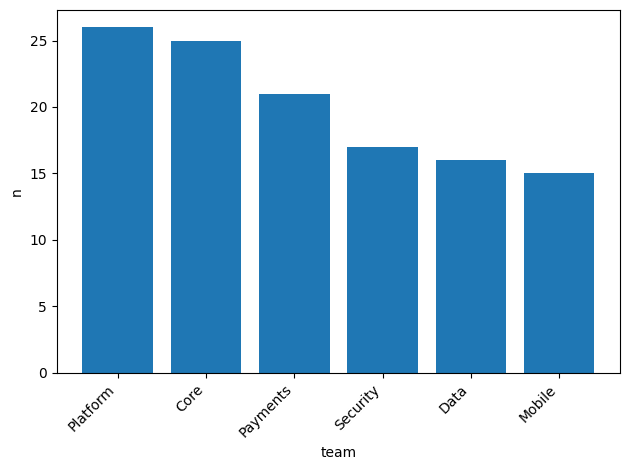

In [9]:
def maybe_plot(df_out: pd.DataFrame):
    if df_out is None or df_out.empty:
        return

    # If it looks like a simple group-by result (category + value), bar chart it
    if df_out.shape[1] == 2:
        x, y = df_out.columns
        if pd.api.types.is_numeric_dtype(df_out[y]):
            plt.figure()
            plt.bar(df_out[x].astype(str), df_out[y])
            plt.xticks(rotation=45, ha="right")
            plt.xlabel(x)
            plt.ylabel(y)
            plt.tight_layout()
            plt.show()

demo2 = run_query("Show counts by team", con)
demo2
maybe_plot(demo2)

In [10]:
EVAL = [
    ("How many apps are in production?", lambda df: int(df.iloc[0,0]) >= 0),
    ("Show the top 10 apps by monthly active users", lambda df: df.shape[0] == 20 or df.shape[0] == 10 or df.shape[0] > 0),
    ("Which apps had the most incidents in the last 30 days?", lambda df: "incidents_last_30d" in df.columns),
    ("Count apps by team", lambda df: "team" in df.columns and df.shape[0] > 1),
]

results = []
for question, check in EVAL:
    df_out = run_query(question, con)
    passed = df_out is not None and check(df_out)
    results.append({"question": question, "passed": passed})

pd.DataFrame(results)

Question: How many apps are in production?

Generated SQL:
 SELECT COUNT(*) AS n FROM apps WHERE overall_status = 'in_production' LIMIT 200;

Validation: OK
Question: Show the top 10 apps by monthly active users

Generated SQL:
 SELECT app_name, monthly_active_users FROM apps ORDER BY monthly_active_users DESC LIMIT 20;

Validation: OK
Question: Which apps had the most incidents in the last 30 days?

Generated SQL:
 SELECT app_name, incidents_last_30d FROM apps ORDER BY incidents_last_30d DESC LIMIT 20;

Validation: OK
Question: Count apps by team

Generated SQL:
 SELECT team, COUNT(*) AS n FROM apps GROUP BY team ORDER BY n DESC LIMIT 200;

Validation: OK


,question,passed
0,How many apps are in production?,True
1,Show the top 10 apps by monthly active users,True
2,Which apps had the most incidents in the last ...,True
3,Count apps by team,True
